# Multiclass Partition Explainer: Emotion Data Example

This notebook demonstrates how to use the partition explainer for multiclass scenario with text data and visualize feature attributions towards individual classes. For computing shap values for a multiclass scenario, it uses the partition explainer over the text data and computes attribution for a feature towards a given class based on its marginal contribution towards the difference in the one vs all logit for the respective class from its base value. 

Below we demonstrate using the partition explainer on the Emotion dataset provided hugging face and the Emo-MobileBERT (https://huggingface.co/lordtt13/emo-mobilebert) which is a thin version of BERT LARGE, trained on the Emotion dataset to infer the underlying emotion of utterance by choosing from four emotion classes: happy, sad, angry and others

In [2]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)
from datasets import load_dataset

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (pyOpenSSL 20.0.1 (c:\users\v-maxtell\miniconda3\envs\interpret_cpu\lib\site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (numpy 1.19.5 (c:\users\v-maxtell\miniconda3\envs\interpret_cpu\lib\site-packages), Requirement.parse('numpy<=1.19.3; sys_platform == "win32"'), {'azureml-dataset-runtime'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (pyOpenSSL 20.0.1 (c:\users\v-maxtell\miniconda3\envs\interpret_cpu\lib\site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load e

### Load data

In [3]:
train, test = load_dataset("emo", split = ["train", "test"])

Reusing dataset emo (C:\Users\v-maxtell\.cache\huggingface\datasets\emo\emo2019\1.0.0\2eedb71b1ce4a28c86a941781403b0e0694f9a794ae6a7eba56b686c4c85f12c)


In [4]:
id2label = {0: 'others', 1: 'happy', 2: 'sad', 3: 'angry'}
labels=list(id2label.values())
label2id = {}
for i,label in enumerate(labels):
    label2id[label]=i

In [5]:
data={'text':[],
     'emotion':[]}
for val in train:
    if id2label[val['label']]!='others':
        data['text'].append(val['text'])
        data['emotion'].append(id2label[val['label']])
        
data = pd.DataFrame(data)

### Load model and tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained("lordtt13/emo-mobilebert",use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("lordtt13/emo-mobilebert")

### Distribution of emotion labels 

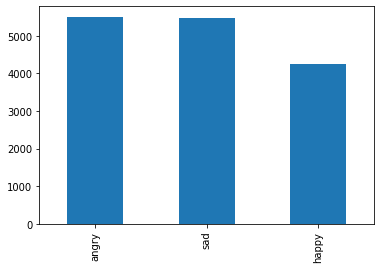

In [7]:
ax = data.emotion.value_counts().plot.bar()


### Sample data

In [8]:
data.head()

,text,emotion
0,when did i saw many times i think no i never saw you,angry
1,u r ridiculous i might be ridiculous but i am telling the truth u little disgusting whore,angry
2,i hate my boyfriend you got a boyfriend yes,angry
3,bad bad bad that's the bad kind of bad i have no gf,sad
4,money money and lots of moneysmilingfacewithhearteyessmilingfacewithhearteyes i need to get it tailored but i'm in love with it smilingfacewithhearteyes beamingfacewithsmilingeyesbeamingfacewithsmilingeyes,happy


### Define function

In [9]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=128,truncation=True) for v in x])
    attention_mask = (tv!=0).type(torch.int64)
    outputs = model(tv,attention_mask=attention_mask)[0].detach().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores) 
    return val

### Create an explainer object

In [10]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

### Compute shap values for multiclass scenario

In [14]:
type(data['text'][0:50])

pandas.core.series.Series

In [11]:
shap_values_multiclass = explainer(data['text'][0:50])

ValueError: cannot reshape array of size 1 into shape (2)

In [ ]:
print(shap_values_multiclass.clustering)

### Wrapper functions for bar and text plots

In [11]:
def custom_masked_bar_plot(class_index,mask_type,viz_type):
    #determine type of operation on the explanation object
    if viz_type=='mean':
        compute_shap=copy.copy(shap_values_multiclass.mean(0))
    if viz_type=='sum':
        compute_shap=copy.copy(shap_values_multiclass.sum(0))
    if viz_type=='abs_mean':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    if viz_type=='abs_sum':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    #create a mask to visualize either positively or negatively contributing features
    if mask_type=='pos':
        mask=compute_shap.values[:,class_index]>=0
    else:
        mask=compute_shap.values[:,class_index]<=0
    #slice values related to a given class
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    #plot
    shap.plots.bar(compute_shap.abs,order=shap.Explanation.identity)

In [12]:
def text_plot(class_index,start_idx,end_idx):
    shap_values = copy.copy(shap_values_multiclass[:])
    #slice values related to a given class
    if len(shap_values.base_values.shape) == 1:
        shap_values.values = shap_values.values[:,class_index]
        shap_values.hierarchical_values = shap_values.hierarchical_values[:,class_index]
        shap_values.base_values = shap_values.base_values[class_index]
    else:
        for i in range(start_idx,end_idx):
            shap_values.values[i] = shap_values.values[i][:,class_index]
            shap_values.hierarchical_values[i] = shap_values.hierarchical_values[i][:,class_index]
        shap_values.base_values = shap_values.base_values[:,class_index]
    #plot
    shap.plots.text(shap_values[start_idx:end_idx])

### Top words towards emotion happy

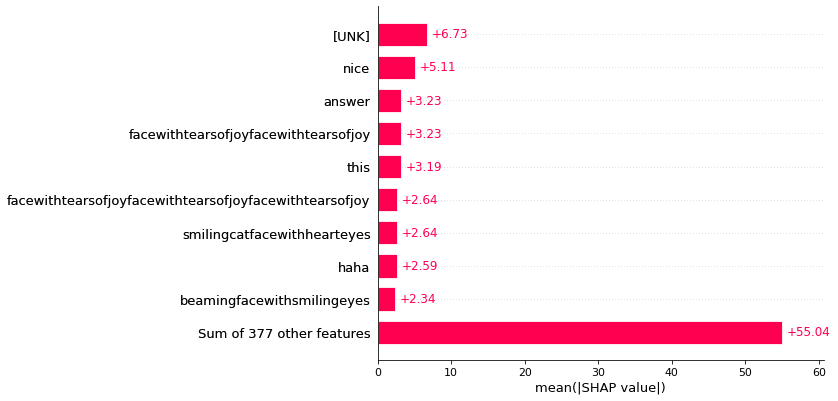

In [13]:
label='happy'
shap.plots.bar(shap_values_multiclass.abs.mean(0)[:,label2id[label]])

### Top positive words towards emotion happy

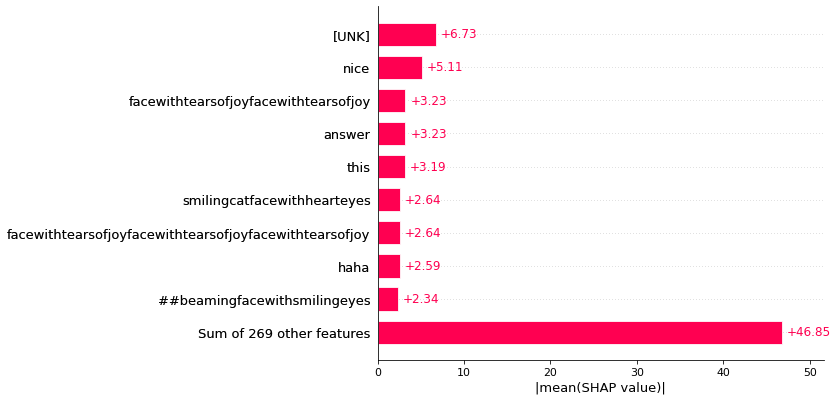

In [27]:
label='happy'
custom_masked_bar_plot(label2id[label],'pos','mean')


### Top negative words towards emotion happy

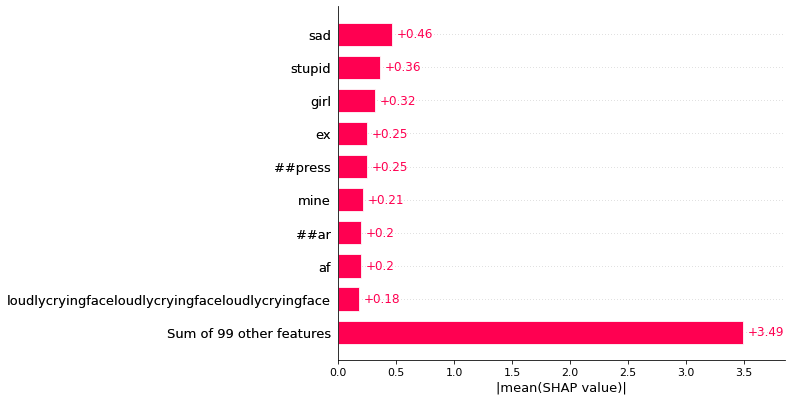

In [28]:
label='happy'
custom_masked_bar_plot(label2id[label],'neg','mean')

### Top words towards emotion sad

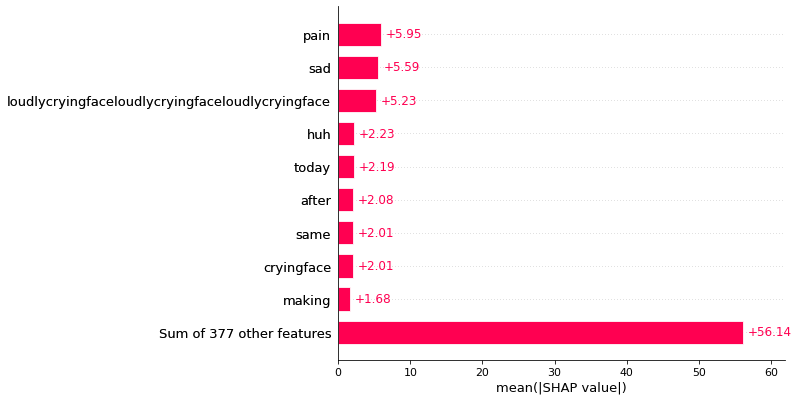

In [29]:
label='sad'
shap.plots.bar(shap_values_multiclass.abs.mean(0)[:,label2id[label]])

### Top positive words towards emotion sad

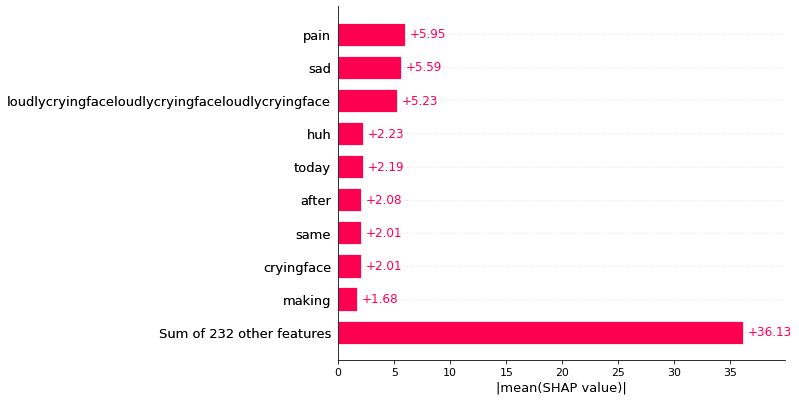

In [30]:
label='sad'
custom_masked_bar_plot(label2id[label],'pos','mean')

### Top negative words towards emotion sad

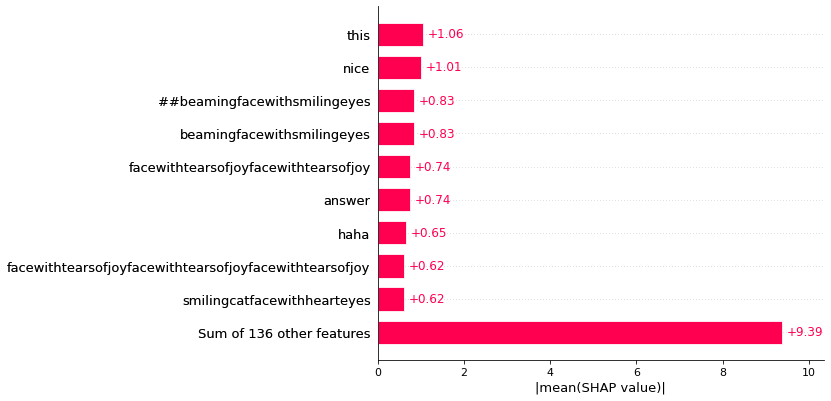

In [31]:
label='sad'
custom_masked_bar_plot(label2id[label],'neg','mean')

### Top words towards emotion angry

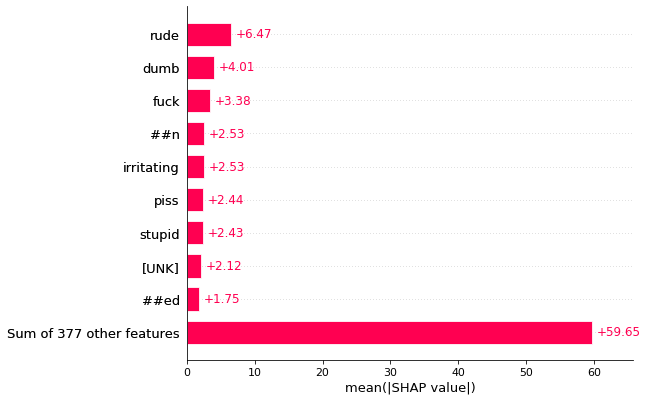

In [32]:
label='angry'
shap.plots.bar(shap_values_multiclass.abs.mean(0)[:,label2id[label]])

### Top positive words towards emotion angry

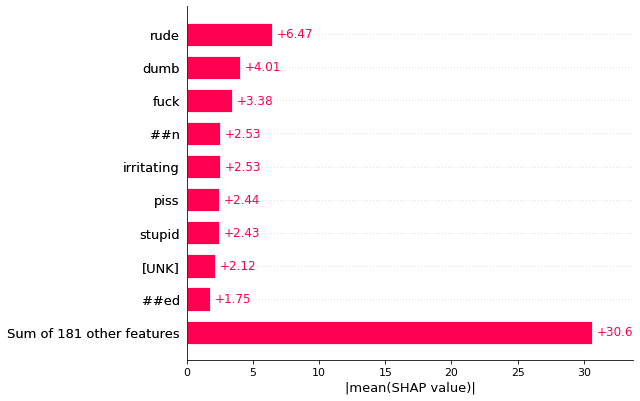

In [33]:
label='angry'
custom_masked_bar_plot(label2id[label],'pos','mean')

### Top negative words towards emotion angry

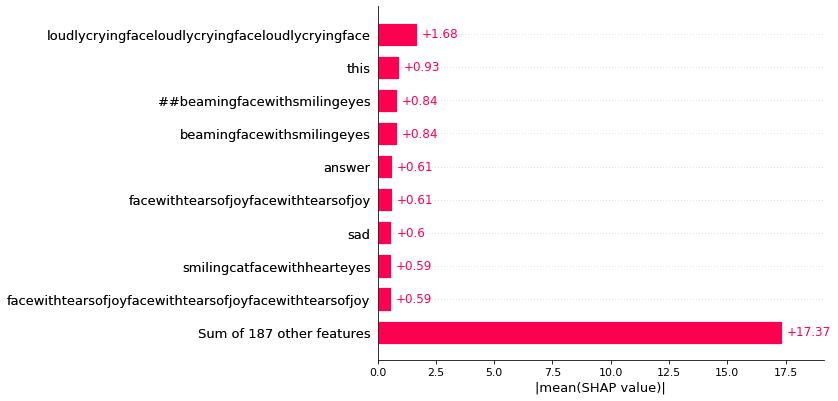

In [34]:
label='angry'
custom_masked_bar_plot(label2id[label],'neg','mean')

### Visualizing text plots over attribution of features towards a given class

In [35]:
label='sad'
text_plot(label2id[label],0,3)

KeyError: ('numpy', 'float64')